In [1]:
import os

import numpy as np
import math
import uproot as uproot
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import gridspec
import dunestyle.matplotlib as dunestyle

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import median_abs_deviation
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import Bounds, LinearConstraint
from scipy.stats import chisquare

from landaupy import langauss

from branches import *
from pandas_helpers import *

DUNE plot style enabled


In [2]:
PDG = {
    "muon": [13, "muon", 0.105,],
    "proton": [2212, "proton", 0.938272,], 
    "neutron": [2112, "neutron", 0.9395654,], 
    "pizero": [111, "pizero", 0.1349768], 
    "piplus": [211, "piplus", 0.13957039], 
    "piminus": [-211, "piminus", 0.13957039], 
    "argon": [1000180400, "argon", (18*0.938272 + 22*0.9395654)], 
    "gamma": [22, "gamma", 0 ], 
    "lambda": [3122, "lambda", 1.115683], 
    "kaon_p": [321, "kaon_p",  0.493677], 
    "sigma_p": [3222, "sigma_p", 1.18936], 
    "kaon_0": [311, "kaon_0", 0.497648], 
    "sigma_0": [3212, "sigma_0", 1.19246], 
    "lambda_p_c": [4122, "lambda_p_c", 2.28646], 
    "sigma_pp_c": [4222, "sigma_pp_c", 2.45397], 
    "electron": [11, "electron", 0.510998950], 
    "sigma_p_c": [4212, "sigma_p_c", 2.4529],
}

THRESHOLD = {"muon": 0.175, "proton": 0.3, "proton_stub": 0.2, "picharged": 0.07, "pizero":0}

In [3]:
def InFV(data): # cm
    xmin = -199.15 + 10
    ymin = -200. + 10
    zmin = 0.0 + 10
    xmax = 199.15 - 10
    ymax =  200. - 10
    zmax =  500. - 50
    return (data.x > xmin) & (data.x < xmax) & (data.y > ymin) & (data.y < ymax) & (data.z > zmin) & (data.z < zmax)

def InBeam(t):
    return (t > 0.) & (t < 1.800)

def Avg(df, pid, drop_0=True):  # average score of 3 planes, exclude value if 0
    if drop_0:
        df = df.replace(0, np.nan)
    average = df[[("chi2pid", "I0", "chi2_"+pid), ("chi2pid", "I1", "chi2_"+pid), ("chi2pid", "I2", "chi2_"+pid)]].mean(skipna=drop_0, axis=1)
    return average

def Signal(df): # signal definition
    is_fv = InFV(df.nu.position)
    is_numu = (df.nu.pdg == 14)
    is_cc = (df.nu.iscc == 1)
    is_1p0pi = (df.mult_proton_def == 1) & (df.mult_picharged_def == 0) & (df.mult_pizero == 0)
    return is_fv & is_numu & is_cc # & is_1p0pi

In [4]:
#fname = '/Users/sungbino/Study/FNAL/SBND/data/flatcaf/2023B/GENIE_CV/caf.flat.caf-993b3810-d027-402c-8486-f42abb1b0bd3.root'
#fname = '/Users/sungbino/Study/FNAL/SBND/data/flatcaf/2024A_test/2024_genie_cv/reco2_hadd.root'
fname = '/Users/sungbino/Study/FNAL/SBND/data/flatcaf/2024A_test/2024_genie_cv/reco2_5_files_hadd.root'
events = uproot.open(fname+":recTree")

In [5]:
# MC truth
nudf = loadbranches(events, mc_branches)
nudf = nudf.rec.mc

nuprimdf = loadbranches(events, mc_prim_branches)
nuprimdf = nuprimdf.rec.mc.nu
nuprimdf[("prim","totp","")] = np.sqrt((nuprimdf.prim.startp.x)**2+(nuprimdf.prim.startp.y)**2+(nuprimdf.prim.startp.z)**2) # |momentum| branch

# primary track multiplicity
mult_muon = (nuprimdf.prim.pdg == 13).groupby(level=[0,1]).sum()
mult_muon_def = ((nuprimdf.prim.pdg == 13) & (nuprimdf.prim.totp > THRESHOLD["muon"])).groupby(level=[0,1]).sum()
mult_proton = (nuprimdf.prim.pdg == 2212).groupby(level=[0,1]).sum()
mult_proton_def = ((nuprimdf.prim.pdg == 2212) & (nuprimdf.prim.totp > THRESHOLD["proton"])).groupby(level=[0,1]).sum()
mult_proton_stub_def = ((nuprimdf.prim.pdg == 2212) & (nuprimdf.prim.totp > THRESHOLD["proton_stub"])).groupby(level=[0,1]).sum()
mult_picharged = (np.abs(nuprimdf.prim.pdg) == 211).groupby(level=[0,1]).sum()
mult_picharged_def = ((np.abs(nuprimdf.prim.pdg) == 211) & (nuprimdf.prim.totp > THRESHOLD["picharged"])).groupby(level=[0,1]).sum()
mult_pizero = (np.abs(nuprimdf.prim.pdg) == 211).groupby(level=[0,1]).sum()
mult_pizero_def = ((np.abs(nuprimdf.prim.pdg) == 111) & (nuprimdf.prim.totp > THRESHOLD["pizero"])).groupby(level=[0,1]).sum()
mult_electron = (nuprimdf.prim.pdg == 11).groupby(level=[0,1]).sum()
mult_photon = (nuprimdf.prim.pdg == 22).groupby(level=[0,1]).sum()
nudf['mult_muon'] = mult_muon
nudf['mult_muon_def'] = mult_muon_def
nudf['mult_proton'] = mult_proton
nudf['mult_proton_def'] = mult_proton_def
nudf['mult_proton_stub_def'] = mult_proton_stub_def
nudf['mult_picharged'] = mult_picharged
nudf['mult_picharged_def'] = mult_picharged_def
nudf['mult_pizero'] = mult_pizero
nudf['mult_pizero_def'] = mult_pizero_def
nudf['mult_electron'] = mult_electron
nudf['mult_photon'] = mult_photon

# truth match
slcdf = loadbranches(events, slc_branches)
slcdf = slcdf.rec

slcdf.loc[np.invert(slcdf[("slc","tmatch","eff")] > 0.5) & (slcdf[("slc","tmatch","idx")] >= 0), ("slc","tmatch","idx")] = np.nan
slcdf["tmatch_index"] = slcdf[("slc", "tmatch", "idx")]

matchdf = pd.merge(slcdf.reset_index(), 
                 nudf.reset_index(),
                 left_on=[("entry", "",""), ("slc","tmatch", "idx")], # entry index -> neutrino index
                 right_on=[("entry", "",""), ("rec.mc.nu..index", "","")], 
                 how="left", # Keep every slc
                 )

matchdf = matchdf.set_index(["entry", "rec.slc..index"], verify_integrity=True)

/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)


In [6]:
# reco pfps
pfptrkdf = loadbranches(events, pfp_trk_branches)
pfptrkdf = pfptrkdf.rec.slc.reco.pfp

pfptrkchi2df = loadbranches(events, pfp_trk_chi2_branches)
pfptrkchi2df = pfptrkchi2df.rec.slc.reco.pfp.trk

pfptrkdf = pfptrkdf.join(pfptrkchi2df)

pfptruthdf = loadbranches(events, pfp_trk_mc_branches)
pfptruthdf = pfptruthdf.rec.slc.reco.pfp.trk.truth

pfpdf = pd.merge(pfptrkdf, pfptruthdf, left_index=True, right_index=True, how="inner")

pandoradf = loadbranches(events, pandora_branches)
pandoradf = pandoradf.rec.slc

pfpdf = pd.merge(pfpdf, pandoradf, left_index=True, right_index=True, how="inner")

# merge all
masterdf = pd.merge(matchdf, pfpdf, left_index=True, right_index=True, how="inner")

/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)


In [7]:
## reco pfp track hits
pfptrkhit0df = loadbranches(events, pfp_trk_hit0_branches)
pfptrkhit1df = loadbranches(events, pfp_trk_hit1_branches)
pfptrkhit2df = loadbranches(events, pfp_trk_hit2_branches)
pfptrkhit0df = pfptrkhit0df.rec.slc.reco.pfp.trk.calo.I0.points
pfptrkhit1df = pfptrkhit1df.rec.slc.reco.pfp.trk.calo.I1.points
pfptrkhit2df = pfptrkhit2df.rec.slc.reco.pfp.trk.calo.I2.points

pfptrkhit0df.index.set_names("rec.slc.reco.pfp.trk.calo.points..index", level="rec.slc.reco.pfp.trk.calo.0.points..index", inplace=True)
pfptrkhit1df.index.set_names("rec.slc.reco.pfp.trk.calo.points..index", level="rec.slc.reco.pfp.trk.calo.1.points..index", inplace=True)
pfptrkhit2df.index.set_names("rec.slc.reco.pfp.trk.calo.points..index", level="rec.slc.reco.pfp.trk.calo.2.points..index", inplace=True)

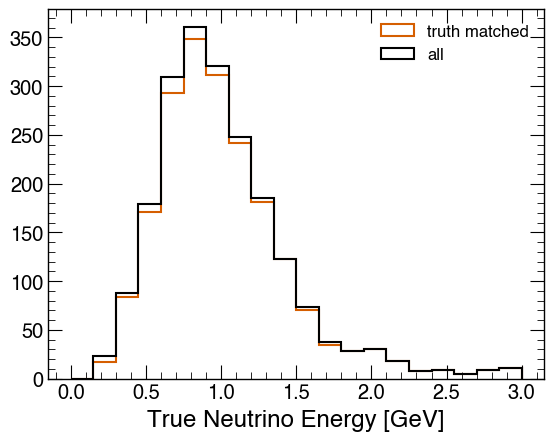

In [8]:
# truth match efficiency
nu_idx = matchdf.reset_index().set_index(["entry", "rec.mc.nu..index"]).index.unique()

nu_idx = [idx for idx in nu_idx if not math.isnan(idx[1])]

nudf_tmatched = nudf.loc[nu_idx]
var = [nudf[Signal(nudf)].nu.E, nudf_tmatched[Signal(nudf_tmatched)].nu.E]
plt.hist(var, bins=np.linspace(0,3,21), histtype="step", label=["all", "truth matched"])
plt.xlabel("True Neutrino Energy [GeV]")
plt.legend()
plt.show();

In [9]:
# reco vertex in FV
cut = InFV(masterdf.slc.vertex)
df_vertexcut = masterdf[cut]

In [10]:
# cosmic rejection
cut_nuscore = (df_vertexcut.slc.nu_score.squeeze() > 0.4)
cut_fmatch = ((df_vertexcut.slc.fmatch.score < 7.0) & (InBeam(df_vertexcut.slc.fmatch.time)))
df_cosmiccut = df_vertexcut[cut_nuscore & cut_fmatch]

In [11]:
# Long muon selection
MUCUT_LEN_THRES = 100
cut_len = (df_cosmiccut.trk.len > MUCUT_LEN_THRES)
primary_muons = df_cosmiccut[cut_len]
primary_muons = primary_muons.sort_values(["entry", "rec.slc..index", ("trk","len","")], ascending=[True, True, False])
leading_muon = primary_muons.groupby(["entry", "rec.slc..index"]).head(1) 
slc_idx_1mu = leading_muon.reset_index().set_index(["entry", "rec.slc..index"]).index.unique()
df_1mucut = df_cosmiccut.reset_index().set_index(["entry", "rec.slc..index"]).loc[slc_idx_1mu]
df_1mucut = df_1mucut.reset_index().set_index(["entry", "rec.slc..index", "rec.slc.reco.pfp..index"], verify_integrity=True)

In [56]:
# Track score cut
cut_trk_score = (leading_muon[('reco',      'pfp', 'trackScore')] > 0.5)
trk_muon = leading_muon[cut_trk_score]

In [57]:
# Contained muon selection
#cut_contained = (InFV(df_1mucut[('trk', 'start')])) & InFV(df_1mucut[('trk', 'end')])
cut_contained = (InFV(trk_muon[('trk', 'start')])) & InFV(trk_muon[('trk', 'end')])
df_contained_muon = trk_muon[cut_contained]

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_50082/1145576051.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  cut_contained = (InFV(trk_muon[('trk', 'start')])) & InFV(trk_muon[('trk', 'end')])


In [63]:
hit_branches = pfptrkhit0df.columns.tolist()
hit0_sel_df = pd.merge(pfptrkhit0df.reset_index(), df_contained_muon.reset_index(),
                        left_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")],
                        right_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")], 
                        how="inner",
                        )

hit1_sel_df = pd.merge(pfptrkhit1df.reset_index(), df_contained_muon.reset_index(),
                        left_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")],
                        right_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")], 
                        how="inner",
                        )

hit2_sel_df = pd.merge(pfptrkhit2df.reset_index(), df_contained_muon.reset_index(),
                        left_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")],
                        right_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")], 
                        how="inner",
                        )

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_50082/3674698441.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 3 on the right)
  hit0_sel_df = pd.merge(pfptrkhit0df.reset_index(), df_contained_muon.reset_index(),
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_50082/3674698441.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  hit0_sel_df = pd.merge(pfptrkhit0df.reset_index(), df_contained_muon.reset_index(),
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_50082/3674698441.py:8: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 3 on the right)
  hit1_sel_df = pd.merge(pfptrkhit1df.reset_index(), df_contained_muon.reset_index(),
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_50082/3674698441.py:8: PerformanceWarning: 

In [64]:
pdg_list = hit0_sel_df[('p', 'pdg', '')].value_counts()
print(pdg_list)

 13      110176
 2212      5719
-211        749
-13         686
 211        181
 22          80
Name: (p, pdg, ), dtype: int64


In [60]:
#hit0_sel_df = hit0_sel_df.set_index(["entry", "rec.slc..index", "rec.slc.reco.pfp..index", "rec.slc.reco.pfp.trk.calo.points..index"], verify_integrity=True)[hit_branches]
#hit1_sel_df = hit1_sel_df.set_index(["entry", "rec.slc..index", "rec.slc.reco.pfp..index", "rec.slc.reco.pfp.trk.calo.points..index"], verify_integrity=True)[hit_branches]
#hit2_sel_df = hit2_sel_df.set_index(["entry", "rec.slc..index", "rec.slc.reco.pfp..index", "rec.slc.reco.pfp.trk.calo.points..index"], verify_integrity=True)[hit_branches]
#hit0_sel_df = hit0_sel_df[hit_branches]
#hit1_sel_df = hit1_sel_df[hit_branches]
#hit2_sel_df = hit2_sel_df[hit_branches]

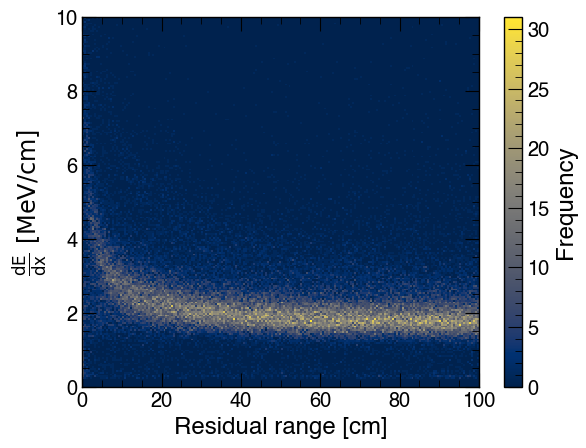

In [65]:
plt.hist2d(hit0_sel_df['rr'], hit0_sel_df['dedx'], bins=200, range = [[0, 100],[0,10]])
plt.colorbar(label='Frequency')
plt.xlabel('Residual range [cm]')
plt.ylabel(r'$\mathrm{\frac{dE}{dx}~[MeV/cm]}$')
#plt.savefig('./life_time/plots_2d/t_drift_vs_dqdx.pdf')
plt.show()

In [66]:
# Check above distribution for different pdg
#plt.clf()
#plt.hist2d(hit0_sel_df['rr'], hit0_sel_df['dedx'], bins=200, range = [[0, 100],[0,10]])

In [92]:
# Fitting for residual range slices
import numpy as np
from landaupy import langauss
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit

def fit_langauss(x, y, y_err):
	area_guess = np.sum(y) * 0.05 / (x[1] - x[0])
	landau_x_mpv_guess = x[np.argmax(y)]
	landau_xi_guess = 0.1
	gauss_sigma_guess = 0.1
	popt, pcov = curve_fit(
		lambda x, area, mpv, xi, g_sigma: area * langauss.pdf(x, mpv, xi, g_sigma),
		xdata = x,
		ydata = y,
		sigma = y_err,
		p0 = [area_guess, landau_x_mpv_guess, landau_xi_guess, gauss_sigma_guess],
	)
	return popt, pcov

def langau_func(x, area, mpv, xi, g_sigma):
    return area * langauss.pdf(x, mpv, xi, g_sigma)

def rr_to_str(rr):
    rr_str = ""
    if(rr < 10):
        rr_str = "0"
        rr_str = rr_str + format(rr, '.2f') + "cm"
    else:
        rr_str = format(rr, '.2f') + "cm"
    return rr_str

def rr_vs_dedx_langau(hitdf, prefix, suffix):
    rr_min = 3.0
    rr_max = 120.0
    rr_step = 1.0
    this_hitdf = hitdf
    this_hitdf['rr_bins'] = pd.cut(this_hitdf['rr'], bins=np.arange(rr_min, rr_max + rr_step, rr_step))
    rr_group_df = this_hitdf.groupby('rr_bins')

    out_df = pd.DataFrame({
        'rr': [],
        'MPV': [],
        'MPV_err': [],
        'sigma_L': [],
        'sigma_L_err': [],
        'sigma_G': [],
        'sigma_G_err': []
    })

    for i, (group_name, group_data) in enumerate(rr_group_df):
        rr_low = rr_min + rr_step * i
        rr_high = rr_min + rr_step * (i + 1)
        this_file_name = './plots/rr_vs_dedx/1d/' + prefix + 'dedx_' + rr_to_str(rr_low) + 'to' + rr_to_str(rr_high) + suffix + '.pdf'
    
        y, bin_edges = np.histogram(group_data['dedx'], bins=50, range = (0., 10.))
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        mask = np.nonzero(y)
        
        fig, ax = plt.subplots()        
        plt.errorbar(
            x = bin_centers[mask],
            y = y[mask],
            yerr = y[mask]**0.5,
            linewidth=2, capsize=1,
            fmt='ok',
            drawstyle = 'default'
        )
        #plt.title(' ')
        #plt.title(f'Residual range : {group_name} [cm]')
        plt.xlabel(r'$\mathrm{\frac{dE}{dx}~[MeV/cm]}$')
        plt.ylabel('Entries')
        ax.set_ylim(bottom=0)
        
        #popt  : 1 = MPV, 2 = sigma_L, 3 = sigma_G
        popt, pcov = fit_langauss(bin_centers[mask], y[mask], y[mask]**0.5)
        this_rr_center = (rr_high + rr_low) / 2.
        this_MPV_err = pcov[1][1]
        this_sigma_L_err = pcov[2][2]
        this_sigma_G_err = pcov[3][3]

        this_row = {
            'rr': this_rr_center,
            'MPV': popt[1],
            'MPV_err': this_MPV_err,
            'sigma_L': popt[2],
            'sigma_L_err': this_sigma_L_err,
            'sigma_G': popt[3],
            'sigma_G_err': this_sigma_G_err
        }

        out_df = out_df.append(this_row, ignore_index=True)        

        n_div = 500
        curve_x = np.linspace(bin_centers[0], bin_centers[-1], n_div)
        plt.plot(curve_x, langau_func(curve_x, *popt), 'r-', label=r'MPV=%5.2f' % popt[1])
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{L}}$=%5.2f' % popt[2])
        plt.plot([], [], ' ', label=r'$\mathrm{\sigma_{G}}$=%5.2f' % popt[3])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
        ax.text(0.50, 0.95, f'Residual range\n{group_name} [cm]', transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props)
        plt.legend(loc=(0.50, 0.45), fontsize=18)
        #plt.show()
        plt.savefig(this_file_name, bbox_inches='tight', pad_inches=0.1)
        #if i > 2:
        #    break
        plt.close(fig)


    return out_df

In [93]:
langau_fit_par_df = rr_vs_dedx_langau(hit0_sel_df, "plane0_", "")

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_50082/3010623109.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(this_row, ignore_index=True)
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_50082/3010623109.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(this_row, ignore_index=True)
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_50082/3010623109.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out_df = out_df.append(this_row, ignore_index=True)
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_50082/3010623109.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [91]:
langau_fit_par_df

,rr,MPV,MPV_err,sigma_L,sigma_L_err,sigma_G,sigma_G_err
0,[3.5],[3.4082987226102492],[0.0013116369017585733],[0.06545524874245376],[0.00020962498563601405],[1.1448939261332662],[0.0015530397115780165]
1,[4.5],[3.043530930823936],[0.012619160476581638],[0.1000775688108721],[0.0021421250818841517],[0.8855252130014556],[0.005484451741028141]
2,[5.5],[2.938469469568035],[0.0044193681132237775],[0.09554605336796419],[0.0007951359498055569],[0.758578953989912],[0.0023014814482523885]
3,[6.5],[2.72570296131535],[0.0045333306232017215],[0.11396022329011408],[0.001169791193626064],[0.6683086335494877],[0.002933754469835236]
4,[7.5],[2.6544529380188093],[0.005037046597569135],[0.09397428353528668],[0.0012190185371179516],[0.588221914835898],[0.003416741073029199]
...,...,...,...,...,...,...,...
112,[115.5],[1.6281807899650569],[0.000644513112686444],[0.11061342561887609],[0.00034277389636434716],[0.24378773284273209],[0.0009849145822613886]
113,[116.5],[1.6465637645463036],[0.000548594073469379],[0.10352027000544019],[0.00022461640598500762],[0.24864619664789328],[0.000649754171230191]
114,[117.5],[1.642157962618799],[0.0007040176037749399],[0.09058926099957987],[0.0003126244526054147],[0.23764933451050904],[0.0008511004810327087]
115,[118.5],[1.6454382557151777],[0.0007140213992744229],[0.0938225789304475],[0.00030151685346948746],[0.27621039261690167],[0.0008513360059209464]
